# Imports

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%run -i ../scripts/functions.py
import math

import seaborn as sns

from PIL import Image

In [15]:
path_img = '../data/2017/ISIC-2017_Training_Data/'
file_img = '.jpg'

path_mask = '../data/2017/ISIC-2017_Training_Part1_GroundTruth/'
file_mask = '_segmentation.png'

# Functions

## Image processing

In [16]:
def crop_imgs(df, column):
    # get list of all image numbers to iterate
    img_nums_list = list(df[column])

    # get paths for masks and images
    for img_num in img_nums_list:
        mask = plt.imread(path_mask + img_num + file_mask)
        img = plt.imread(path_img + img_num + file_img)

        # get boraders based on mask
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        top, bottom, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
        center = ((top+bottom) //2, (left + right) //2) # Tuple with the coordinates for the center of the lesion

        # crop images
        mask_cropped = mask[bottom:top, left:right]
        img_cropped = img[bottom:top, left:right]

        # save images
        plt.imsave('../data/processed/images/' + img_num + '_img.jpg', img_cropped)
        plt.imsave('../data/processed/masks/' + img_num + '_mask.png', mask_cropped, cmap='gray')

## Plotting

In [17]:
# plot an image
def plot_img(img_num):
    im = plt.imread(path_img + img_num + file_img)
    plt.imshow(im)

# plot an mask
def plot_mask(img_num):
    ma = plt.imread(path_mask + img_num + file_mask)
    plt.imshow(ma)

# plot image and mask together
def plot_img_mask(img_num):
    im = plt.imread(path_img + img_num + file_img)
    ma = plt.imread(path_mask + img_num + file_mask)

    # Display 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
    axes[0].imshow(im)
    axes[1].imshow(ma, cmap='gray')
    fig.tight_layout()

# funtion to crop to only the lesion and plot
def crop_mask_plot(img_path):
    borders = np.where(img_path == 1) # This will return 2 arrays with the index where the pixels are ones
    top, bottom, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((top+bottom) //2, (left + right) //2) # Tuple with the coordinates for the center of the lesion

    mask_part = mask[bottom:top, left:right]
    plt.imshow(mask_part)

## Feature implementation

In [18]:
# find center of lesion
def find_center(img_path):
    borders = np.where(img_path == 1) # This will return 2 arrays with the index where the pixels are ones
    top, bottom, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((top+bottom) //2, (left + right) //2) # Tuple with the coordinates for the center of the lesion
    return center

# find standard deviation and mean of 
def radial_profile(mask):

    center = find_center(mask)

    # Find perimeter: Veronika's code
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # select coordinates for all pixels belonging to the perimeter
    y, x = np.where(np.array(image_perimeter)) 
    # calculate the distance between the center pixel to all pixels in the perimeter
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    sd, mean = np.std(r), np.mean(r)

    return sd, mean

## Others

In [19]:
# save dataframe to csv
def df_to_csv(df, filename):
    new_file = '../data/processed/' + filename + '.csv'
    df.to_csv(new_file, index=False)

## Testing radial profile function

(0.28606909667339586, 53.4897654376722) <- perfect circle
(79.6996521617291, 305.7638367507567) <- image from dataset (not cancer)
(236.3002384193509, 602.9752908434656) <- image from dataset (cancer)


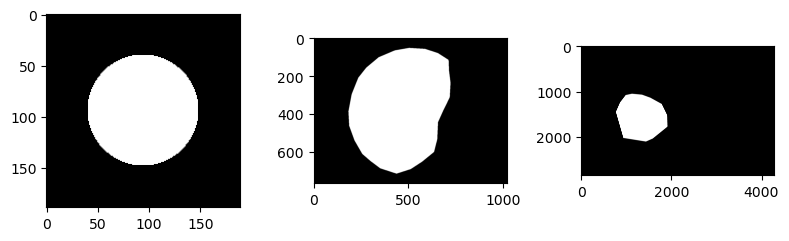

In [20]:
from skimage import io, color

perfect_circle = plt.imread('../data/perfect_circle.png')
perfect_circle = color.rgb2gray(color.rgba2rgb(perfect_circle))
perfect_circle = (perfect_circle > 0).astype(int)

img_test1 = plt.imread('../data/2017/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000004_segmentation.png')
img_test2 = plt.imread('../data/2017/ISIC-2017_Training_Part1_GroundTruth/ISIC_0002885_segmentation.png')

print(radial_profile(perfect_circle), '<- perfect circle')
print(radial_profile(img_test1), '<- image from dataset (not cancer)')
print(radial_profile(img_test2), '<- image from dataset (cancer)')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 6))
axes[0].imshow(perfect_circle, cmap='gray')
axes[1].imshow(img_test1, cmap='gray')
axes[2].imshow(img_test2, cmap='gray')
fig.tight_layout()

# File processing

### Raw
Files downloaded from the internet.

In [21]:
raw = pd.read_csv('../data/2017/ISIC-2017_Training_Part3_GroundTruth.csv')
raw_df = pd.DataFrame(raw)
melanoma = raw_df[raw_df['melanoma'] == 1]
keratosis = raw_df[raw_df['seborrheic_keratosis'] == 1]
healthy = raw_df.loc[(raw_df['melanoma'] == 0) & (raw_df['seborrheic_keratosis'] == 0)]
# healthy_balanced = healthy.iloc[:melanoma.shape[0],:]

m_h = melanoma.append(healthy) # melanoma and healthy only
m_h_k = m_h.append(keratosis) # all

In [22]:
m_h

,image_id,melanoma,seborrheic_keratosis
2,ISIC_0000002,1.0,0.0
4,ISIC_0000004,1.0,0.0
12,ISIC_0000013,1.0,0.0
21,ISIC_0000022,1.0,0.0
25,ISIC_0000026,1.0,0.0
...,...,...,...
1961,ISIC_0014925,0.0,0.0
1962,ISIC_0014926,0.0,0.0
1963,ISIC_0014929,0.0,0.0
1964,ISIC_0014930,0.0,0.0


## Implementation of my features
Added the following:
- area
- perimeter
- radius standard deviation
- radius mean
- compactness
- diagnosis -> melanoma or not melanoma

In [23]:
def get_features(df, column):
    '''
    Input: list of image numbers.
    Output: radius standard deviation, radius mean, area, perimeter 
    and compactness (aka roundness) for all images in the list.
    '''
    # get list of all image numbers to iterate
    img_nums_list = list(df[column])

    #initialize list of features
    features = list()

    # create the list will features
    for img_num in img_nums_list:
        im = plt.imread(path_mask + img_num + file_mask)
        area, perimeter = measure_area_perimeter(im)
        radius_sd, radius_mean = radial_profile(im)
        features.append([img_num, radius_sd, radius_mean, area, perimeter])
    
    # turn area and perimiter list into a dataframe
    features_df = pd.DataFrame(features)
    features_df.rename(columns = {1: "radius_sd", 2: "radius_mean", 3: "area", 4: "perimeter"}, inplace=True)
    
    # calculate compactness/roundness
    features_df['compactness'] = (features_df['perimeter']**2)/(4 * math.pi * features_df['area'])

    # merge area and perimeter df with the initial dataframe
    MAIN = pd.merge(df, features_df, how='left', left_on='image_id', right_on=0).drop([0], axis=1)

    # calculate the compactness of each skin lesion
    MAIN['compactness'] = (MAIN['perimeter']**2)/(4 * math.pi * MAIN['area'])

    # create a sum of the diagnosis to find healthy and not healthy skin lesions
    MAIN['diagnosis_sum'] = MAIN['melanoma'] + MAIN['seborrheic_keratosis']

    # add new column with group name, mostly for labeling
    MAIN['diagnosis'] = MAIN['melanoma'].map({0: 'not melanoma', 1: 'melanoma'})

    return MAIN

In [24]:
# unbalanced_final = get_features(m_h, 'image_id')

## Files with implemented features

In [27]:
colours = pd.read_csv('../data/all_color_measurements.csv')
colours = colours.drop(['Unnamed: 0', 'melanoma', 'diagnosis'], axis=1)
print(colours.shape)

sym = pd.read_csv('../data/sym_col.csv')
sym = sym.iloc[:,np.r_[1,7:10]]
print(sym.shape)

radius = pd.read_csv('../data/processed/final_unbalanced.csv')
# radius = radius.drop(['radius_norm'], axis=1)
print(radius.shape)

(1746, 17)
(1746, 4)
(1746, 29)


# Merge files
Combining all features in a final file

In [28]:
final = pd.merge(radius, sym, how='left', left_on='image_id', right_on='image_id')
final = pd.merge(final, colours, how='left', left_on='image_id', right_on='image_id').sort_values(by='image_id')

In [29]:
# df_to_csv(final, 'final_unbalanced')

In [30]:
# test dataframe
# test_df = m_h.iloc[:10]
# test_features = get_features(test_df, 'image_id')
# df_to_csv(test_features, 'test')

# re-do main file
# melanoma_healthy_balanced_features = get_features(melanoma_healthy_balanced, 'image_id')
# df_to_csv(melanoma_healthy_balanced_features, 'melanoma_healthy_balanced')

# merge files
# df1 = pd.read_csv('../data/processed/melanoma_healthy_balanced.csv')
# df2 = pd.read_csv('../data/sym_col.csv').drop(['Unnamed: 0', 'melanoma', 'area', 'perimeter', 'diagnosis_sum', 'compactness'], axis=1).rename(columns = {"horisontal_symmetry": "horizontal_symmetry"})

# save final file
# final_balanced = pd.merge(df1, df2, how='left', left_on='image_id', right_on='image_id')
# df_to_csv(final_balanced, 'final_balanced')


# Data exploration

In [31]:
DATA = pd.read_csv('../data/processed/final_balanced.csv')
DATA.head(3)

,image_id,melanoma,seborrheic_keratosis,radius_sd,radius_mean,area,perimeter,compactness,diagnosis_sum,diagnosis,...,r_pct,g_pct,b_pct,r_low,b_high,radius_sd_norm,radius_mean_norm,area_norm,perimeter_norm,compactness_norm
0,ISIC_0000002,1.0,0.0,110.927367,304.913068,237402.0,2071.0,1.437692,1.0,cancerous,...,0.3697,0.3071,0.3233,0.0005,0.2243,0.072284,0.057432,0.010752,0.050473,0.027349
1,ISIC_0000004,1.0,0.0,79.699652,305.763837,269484.0,1746.0,0.900214,1.0,cancerous,...,0.4066,0.2685,0.3249,0.0081,0.4463,0.049505,0.057671,0.012304,0.040627,0.005374
2,ISIC_0000013,1.0,0.0,109.606470,275.459923,192711.0,1635.0,1.103873,1.0,cancerous,...,0.4424,0.3084,0.2493,0.0649,0.0306,0.071321,0.049139,0.008589,0.037264,0.013701


In [32]:
np.min(DATA['radius_sd'])

11.8348170421515

In [33]:
np.max(DATA['radius_sd'])

1382.7077058669297

In [34]:
# seting seaborn theme
sns.set_theme()
cor='mako'

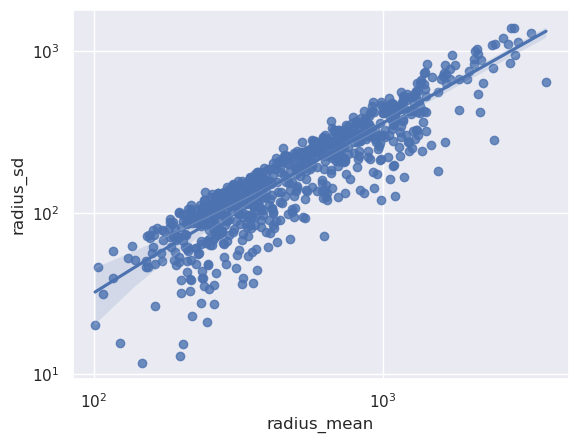

In [36]:
f, ax = plt.subplots()
ax.set(xscale='log', yscale='log')
fig = sns.regplot(y='radius_sd', x='radius_mean', data=DATA, truncate=True, ax=ax)
fig;

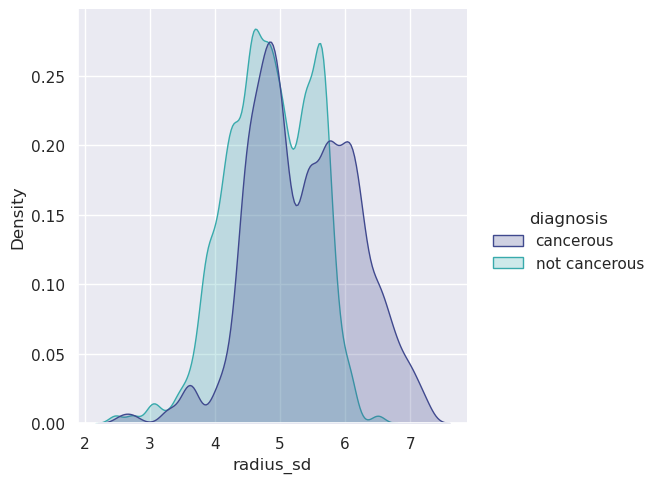

In [37]:
sns.displot(DATA, x=np.log(DATA["radius_sd"]), kind="kde", hue='diagnosis', bw_adjust=.5, fill=True, palette=cor);

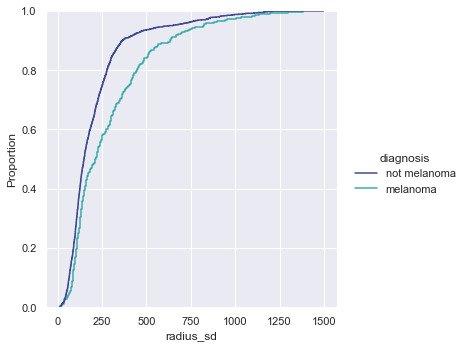

In [ ]:
# dp = DATA[DATA["radius_sd"] > 750]
sns.displot(DATA, x="radius_sd", hue="diagnosis", kind="ecdf", palette=cor)

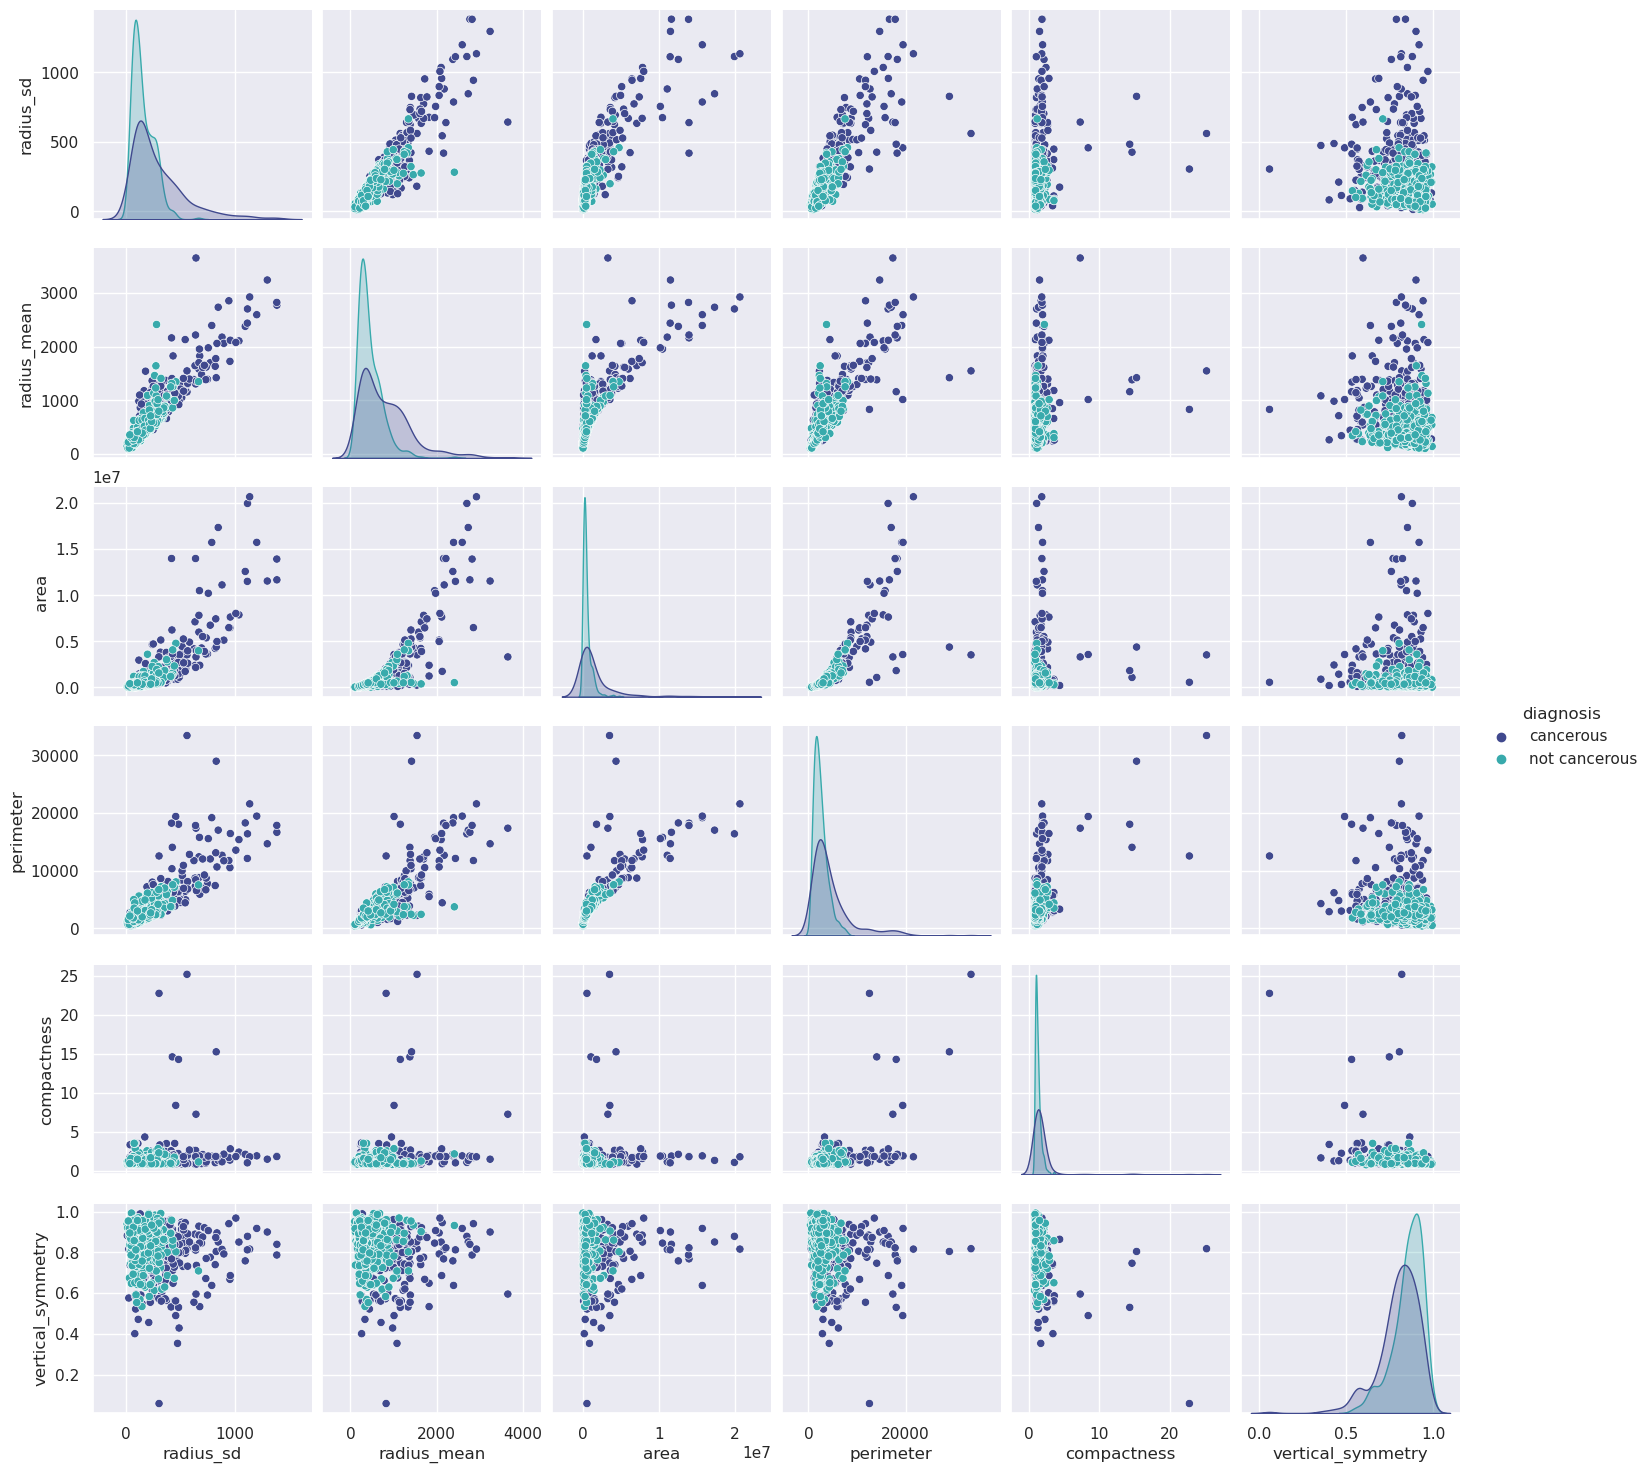

In [38]:
pp = DATA.iloc[:,3:11].drop(['diagnosis_sum'], axis=1)

sns.pairplot(pp, hue='diagnosis', palette=cor);

In [39]:
pp.corr(method='spearman')

,radius_sd,radius_mean,area,perimeter,compactness,vertical_symmetry
radius_sd,1.000000,0.903530,0.815952,0.805842,0.190280,-0.110286
radius_mean,0.903530,1.000000,0.880989,0.877058,0.225097,-0.108805
area,0.815952,0.880989,1.000000,0.966079,0.162050,-0.144690
perimeter,0.805842,0.877058,0.966079,1.000000,0.381549,-0.210575
compactness,0.190280,0.225097,0.162050,0.381549,1.000000,-0.301159
vertical_symmetry,-0.110286,-0.108805,-0.144690,-0.210575,-0.301159,1.000000


In [40]:
pp_colors = DATA.iloc[:,10:]

# sns.pairplot(pp_colors, hue='diagnosis', palette=cor)

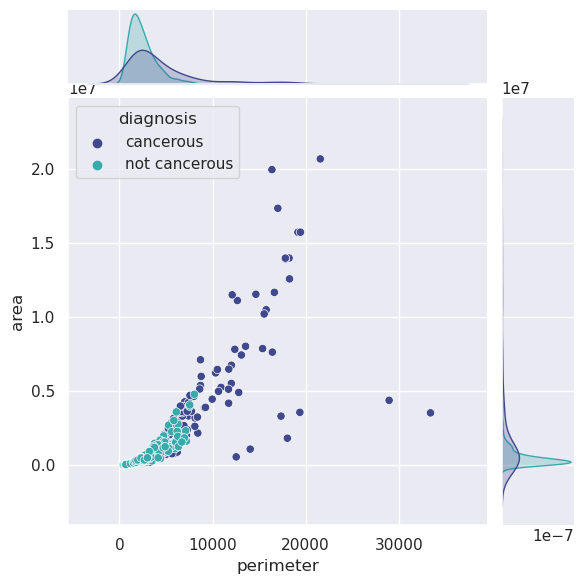

In [41]:
sns.jointplot(
    data=DATA,
    x="perimeter", y="area", hue="diagnosis",
    palette=cor
);

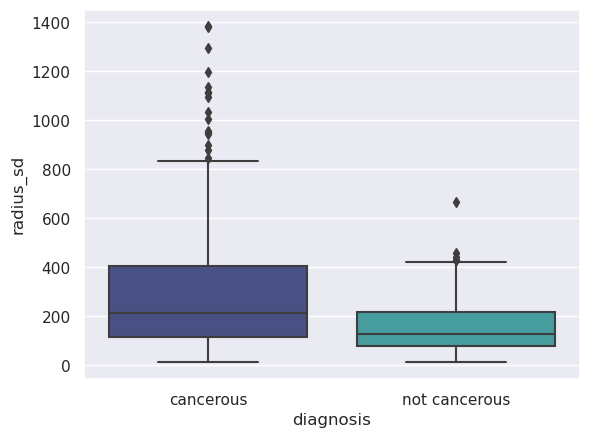

In [42]:
sns.boxplot(x='diagnosis', y='radius_sd', data=DATA, palette=cor);

# Normalise

In [43]:
DATA.columns

Index(['image_id', 'melanoma', 'seborrheic_keratosis', 'radius_sd',
       'radius_mean', 'area', 'perimeter', 'compactness', 'diagnosis_sum',
       'diagnosis', 'vertical_symmetry', 'horisontal_symmetry', 'symmetry',
       'relative_color_variance', 'r_average', 'g_average', 'b_average',
       'r_std', 'g_std', 'b_std', 'average_std', 'r_range', 'g_range',
       'b_range', 'r_pct', 'g_pct', 'b_pct', 'r_low', 'b_high',
       'radius_sd_norm', 'radius_mean_norm', 'area_norm', 'perimeter_norm',
       'compactness_norm'],
      dtype='object')

In [44]:
data_numeric = DATA.loc[:,['radius_sd', 'radius_mean', 'area', 'perimeter', 'compactness']]

In [45]:
from sklearn import preprocessing
min_max = preprocessing.MinMaxScaler()
norm = min_max.fit_transform(data_numeric.values)
norm = pd.DataFrame(norm, columns=['radius_sd', 'radius_mean', 'area', 'perimeter', 'compactness'])
final = final.join(norm, rsuffix='_norm')

In [46]:
# df_to_csv(final, 'final_balanced')

# T-Test

https://www.statology.org/two-sample-t-test-python/

In [47]:
melanoma_df = DATA[DATA['melanoma'] == 1]
healthy_df = DATA.loc[(DATA['melanoma'] == 0) & (DATA['seborrheic_keratosis'] == 0)]
healthy_df = healthy_df.iloc[:melanoma_df.shape[0],:]

In [48]:
group1 = melanoma_df['radius_sd']
group2 = healthy_df['radius_sd']
print(np.var(group1), np.var(group2))

61158.32412099825 9369.37634120275


In [49]:
import scipy.stats as stats

#perform two sample t-test with equal variances
stats.ttest_ind(a=group1, b=group2, equal_var=True)

Ttest_indResult(statistic=10.008508595417181, pvalue=3.2689269003967157e-22)

# Scikit
Implementation of classifiers.

https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [50]:
import sklearn

In [51]:
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()

# Organize our data
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

# Look at our data
print(label_names)
print(labels)
print(feature_names)
print(features)

['malignant' 'benign']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1

In [52]:
from sklearn.model_selection import train_test_split

# Split our data
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)

In [53]:
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)

# Make predictions
preds = gnb.predict(test)
print(preds)

[1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0
 0 1 1]


In [54]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

0.9414893617021277


# Plots for the report

In [55]:

DATA['image_id'].loc[DATA['radius_sd'] == max(DATA['radius_sd'])].iloc[0]

'ISIC_0015045'

(0.28606909667339586, 53.4897654376722) <- perfect circle
(11.8348170421515, 146.70207836533982) <- image from dataset (not cancer)
(1382.7077058669297, 2772.3977524168517) <- image from dataset (cancer)


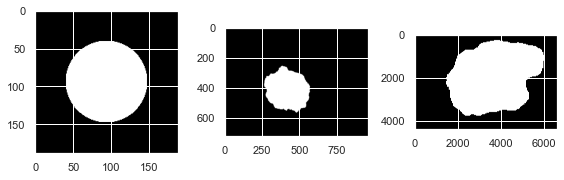

In [ ]:
from skimage import io, color

perfect_circle = plt.imread('../data/perfect_circle.png')
perfect_circle = color.rgb2gray(color.rgba2rgb(perfect_circle))
perfect_circle = (perfect_circle > 0).astype(int)

max_rsd = plt.imread('../data/2017/ISIC-2017_Training_Part1_GroundTruth/' + DATA['image_id'].loc[DATA['radius_sd'] == max(DATA['radius_sd'])].iloc[0] + '_segmentation.png')
min_rsd = plt.imread('../data/2017/ISIC-2017_Training_Part1_GroundTruth/' + DATA['image_id'].loc[DATA['radius_sd'] == min(DATA['radius_sd'])].iloc[0] + '_segmentation.png')

print(radial_profile(perfect_circle), '<- perfect circle')
print(radial_profile(min_rsd), '<- image from dataset (not cancer)')
print(radial_profile(max_rsd), '<- image from dataset (cancer)')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 6))
axes[0].imshow(perfect_circle, cmap='gray')
axes[1].imshow(min_rsd, cmap='gray')
axes[2].imshow(max_rsd, cmap='gray')
fig.tight_layout()